In [5]:
import numpy as np
import matplotlib.pyplot as plt
import folie as fl
import csv


# 1D DOUBLE WEEL POTENTIAL

## 1) The model 


Here we model the double well potential as a quartic function $V(q)= \sum_{i=0}^4 c_iq_i$ and choose a constant diffuion coefficient $D$ :

The force parameter to pass to the simulator will then be : $F = - \frac{dV(q)}{dq}$

In [6]:
coeff=0.1*np.array([0,0,-4.5,0,0.1]) # coefficients of the free energy
free_energy = np.polynomial.Polynomial(coeff)
force_coeff=np.array([-coeff[1],-2*coeff[2],-3*coeff[3],-4*coeff[4]]) #coefficients of the free energy
force_function = fl.functions.Polynomial(deg=3,coefficients=force_coeff)
diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]))

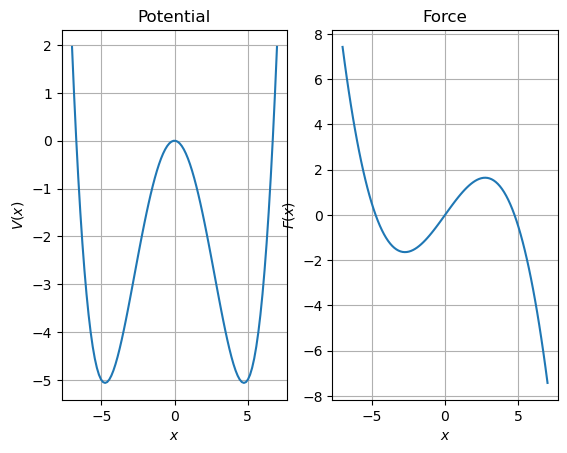

In [7]:
# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_values,free_energy(x_values))
axs[1].plot(x_values,force_function(x_values.reshape(len(x_values),1)))
axs[0].set_title("Potential")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$V(x)$")
axs[0].grid()
axs[1].set_title("Force") 
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$F(x)$") 
axs[1].grid()

## 2) Simulation

In [8]:
# Define model to simulate and type of simulator to use
dt=1e-3
model_simu = fl.models.overdamped.Overdamped(force_function,diffusion=diff_function)
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt) #, k=0.0, xstop=6.0)

In [9]:
ntraj=30
q0= np.empty(ntraj)
for i in range(len(q0)):
    q0[i]=0
# Calculate Trajectory
time_steps=10000
data = simulator.run(time_steps, q0, 1)

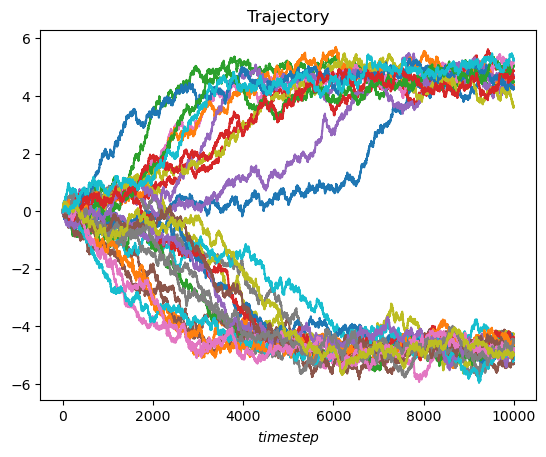

In [13]:
# Plot the trajecories
fig, axs = plt.subplots(1,1)
for n, trj in enumerate(data):
    axs.plot(trj["x"])
    axs.set_title("Trajectory")
    axs.set_xlabel("$timestep$")

## 3) Model Training 

In [83]:
# Parameters of the training
trainforce =fl.functions.Polynomial(deg=2,coefficients=np.asarray([1,1,1]))
traindiff = fl.functions.Polynomial(deg=2,coefficients=np.asarray([1,1,1]))

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)))
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)))
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)))
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)))
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:212: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(self._model.diffusion(x, **kwargs).ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:221: RuntimeWarning: overflow encountered in exp
  B = sig * np.sqrt((np.exp(2 * Lt * dt) - 1) / (2 * Lt))
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:223: RuntimeWarning: overflow encountered in exp
  elt = np.exp(Lt * dt) - 1
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:224: RuntimeWarning: overflow encountered in multiply
  A

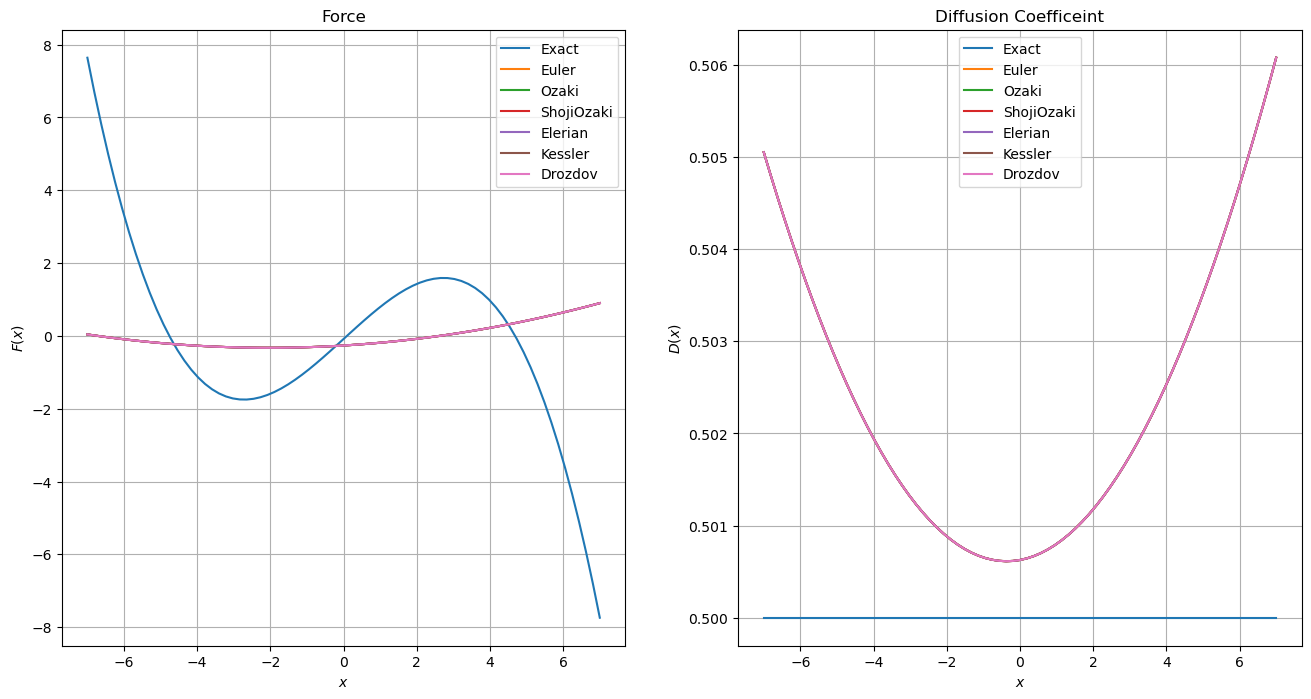

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficeint")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)
# model_simu.remove_bias()

#Plot exact quantities 
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
# axs[0].plot(xfa, Shj_res.force(xfa.reshape(-1, 1)), label='Euler')
# axs[1].plot(xfa, Shj_res.diffusion(xfa.reshape(-1, 1)), label='Euler')
# axs[0].legend()
# axs[1].legend()
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
axs[0].legend()
axs[1].legend()


Calculate the root mean squared deviation of this methods from the exact one 

[0.02409864 0.02409864 0.02409864 0.02409864 0.02409864 0.02409864]


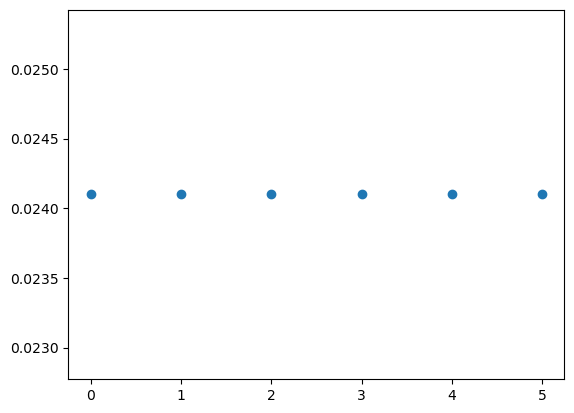

In [81]:

rmsd_force=np.array([ np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Eul_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Ozk_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Shj_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Eln_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Ksl_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Drz_res.force(xfa.reshape(-1, 1)))  ])

rmsd_diffusion=np.array([np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Eul_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Ozk_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Shj_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Eln_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Ksl_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Drz_res.diffusion(xfa.reshape(-1, 1)))  ])

# plt.scatter(np.arange(len(rmsd_force)),rmsd_force)

plt.scatter(np.arange(len(rmsd_diffusion)),rmsd_diffusion)
print(rmsd_diffusion)

/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())


[-8.44381367e-02  9.19038462e-01  6.87872932e-04 -4.11764876e-02
  5.01391057e-01]


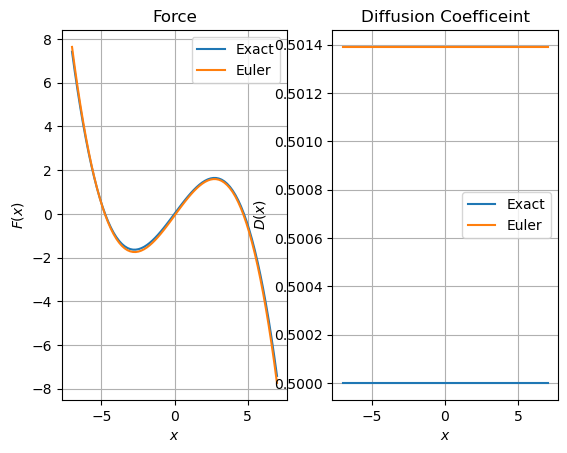

In [11]:
# Begin training part 
fig, axs = plt.subplots(1, 2)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficeint")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)
# model_simu.remove_bias()
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
for name, transitioncls in zip(
   ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"],
   [
    #    fl.EulerDensity,
       fl.OzakiDensity,
    #    fl.ShojiOzakiDensity,
    #    fl.ElerianDensity,
    #    fl.KesslerDensity,
    #    fl.DrozdovDensity,
   ],
):
   estimator = fl.LikelihoodEstimator(transitioncls(fl.models.Overdamped(force = force_function,diffusion=fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.9])), has_bias=False)))
   res = estimator.fit_fetch(data)
   print(res.coefficients)
#    res.remove_bias()
   axs[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
   axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
axs[0].legend()
axs[1].legend()
plt.show() 